In [13]:
!pip uninstall -y transformers huggingface_hub tokenizers
!pip install --no-cache-dir transformers==4.54.1 evaluate seqeval


Found existing installation: transformers 4.54.1
Uninstalling transformers-4.54.1:
  Successfully uninstalled transformers-4.54.1
Found existing installation: huggingface-hub 0.34.3
Uninstalling huggingface-hub-0.34.3:
  Successfully uninstalled huggingface-hub-0.34.3
Found existing installation: tokenizers 0.21.4
Uninstalling tokenizers-0.21.4:
  Successfully uninstalled tokenizers-0.21.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 231.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 344.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 292.0 MB/s eta 0:00:00


In [1]:
import transformers
print("transformers version:", transformers.__version__)

from transformers import TrainingArguments
import inspect
print(inspect.signature(TrainingArguments))


transformers version: 4.54.1
(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict[str, Any], str, NoneType] = <factory>, warm

In [2]:
from datasets import load_dataset
dataset = load_dataset("nielsr/funsd-layoutlmv3")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from transformers import AutoProcessor
from datasets.features import ClassLabel
tokenizer = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [4]:
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

In [5]:
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"


features = dataset["train"].features
column_names = dataset["train"].column_names

if isinstance(features["ner_tags"].feature, ClassLabel):
    label_list = features["ner_tags"].feature.names
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"]["ner_tags"])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [6]:
def encoder(examples):
  images = examples["image"]
  words = examples["tokens"]
  boxes = examples["bboxes"]
  word_labels = examples[label_column_name]

  encoding = tokenizer(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [7]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D


features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    encoder,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    encoder,
    batched=True,
    remove_columns=column_names,
    features=features,
)

In [8]:
train_dataset.set_format("torch")


In [9]:
import torch

In [10]:
import evaluate
metric = evaluate.load("seqeval")


import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


In [11]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test",
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=3,
    learning_rate=1e-5,
    eval_strategy="steps",  # Changed from evaluation_strategy to eval_strategy
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [18]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-3768376911.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amaanmohamed55 (amaanmohamed55-arizona-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1735: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.631030,0.773063,0.832588,0.801722,0.798407
200,No log,0.505742,0.819816,0.883756,0.850586,0.830144
300,No log,0.532201,0.841113,0.886239,0.863087,0.825984
400,No log,0.580272,0.846774,0.886736,0.866295,0.831808
500,0.536300,0.532170,0.860520,0.904123,0.881783,0.830619
600,0.536300,0.622172,0.870406,0.894188,0.882137,0.833947
700,0.536300,0.623927,0.879981,0.910581,0.895020,0.835730
800,0.536300,0.660544,0.878788,0.907601,0.892962,0.838464
900,0.536300,0.661887,0.882268,0.912072,0.896922,0.843338
1000,0.132300,0.679828,0.878657,0.910084,0.894095,0.838940


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1735: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.3342983627319336, metrics={'train_runtime': 624.4667, 'train_samples_per_second': 3.203, 'train_steps_per_second': 1.601, 'total_flos': 523783817001984.0, 'train_loss': 0.3342983627319336, 'epoch': 13.333333333333334})

In [20]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1735: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.5321701765060425,
 'eval_precision': 0.8605200945626478,
 'eval_recall': 0.9041231992051664,
 'eval_f1': 0.8817829457364341,
 'eval_accuracy': 0.8306192796862,
 'eval_runtime': 5.4642,
 'eval_samples_per_second': 9.151,
 'eval_steps_per_second': 3.111,
 'epoch': 13.333333333333334}

In [21]:
trainer.save_model("trained_model")


In [23]:
model = LayoutLMv3ForTokenClassification.from_pretrained("trained_model")

In [24]:
device = torch.device("cuda")
model.cuda()

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [25]:
example = dataset["test"][2]
print(example.keys())

image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = tokenizer(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
encoding = encoding.to('cuda')
for k,v in encoding.items():
  print(k,v.shape)

with torch.no_grad():
  outputs = model.to('cuda')(**encoding)

logits = outputs.logits
logits.shape

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])
input_ids torch.Size([1, 372])
attention_mask torch.Size([1, 372])
bbox torch.Size([1, 372, 4])
labels torch.Size([1, 372])
pixel_values torch.Size([1, 3, 224, 224])


torch.Size([1, 372, 7])

In [26]:
predictions = logits.argmax(-1).squeeze().tolist()
#labels = encoding.labels.squeeze().tolist()


In [28]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

# Extract labels from encoding - UNCOMMENT THIS LINE
labels = encoding.labels.squeeze().tolist()

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != -100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

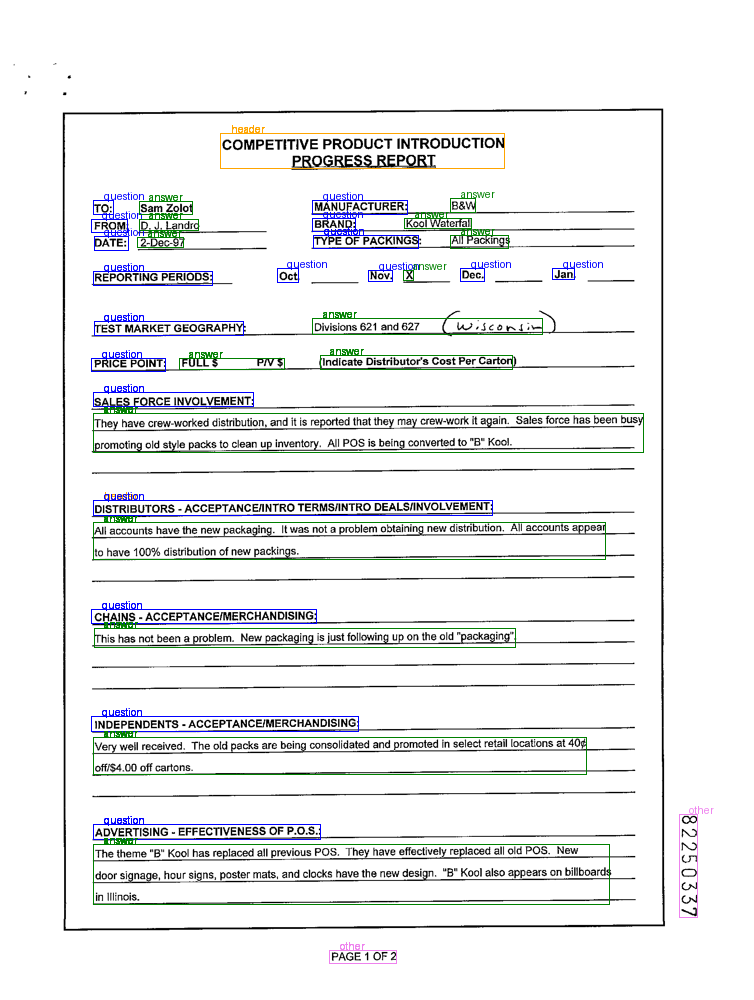

In [29]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image